# Table of Contents
- [Import Library](#import-library)
- [Read In CSV](#read-in-csv)

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

## Read In CSV

In [2]:
eth = pd.read_csv('./ohlcv_hour.csv')

In [3]:
eth.set_index('trading_point', inplace=True)

In [4]:
eth.index

Index(['2018-05-15', '2018-05-15', '2018-05-15', '2018-05-15', '2018-05-15',
       '2018-05-15', '2018-05-15', '2018-05-15', '2018-05-15', '2018-05-15',
       ...
       '2024-01-10', '2024-01-10', '2024-01-10', '2024-01-10', '2024-01-10',
       '2024-01-10', '2024-01-10', '2024-01-10', '2024-01-10', '2024-01-11'],
      dtype='object', name='trading_point', length=49603)

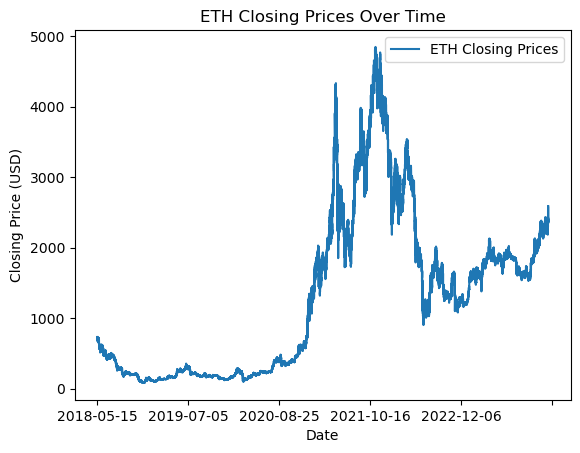

In [5]:
eth.plot.line(y='close', use_index=True, style='-', label='ETH Closing Prices')
plt.title('ETH Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)');

In [6]:
eth['tomorrow'] = eth['close'].shift(-1)
eth

,open,high,low,close,volume,tomorrow
trading_point,,,,,,
2018-05-15,732.10,736.67,730.94,733.00,1.043910e+03,707.38
2018-05-15,700.99,710.15,699.05,707.38,2.558900e+02,700.99
2018-05-15,707.84,711.29,695.74,700.99,1.029830e+03,707.84
2018-05-15,712.48,714.44,707.39,707.84,1.560700e+02,712.48
2018-05-15,713.00,714.99,709.41,712.48,4.185700e+02,713.00
...,...,...,...,...,...,...
2024-01-10,2376.10,2377.80,2346.40,2348.00,2.997900e+05,2377.80
2024-01-10,2399.90,2400.60,2367.10,2377.80,7.287779e+05,2398.10
2024-01-10,2346.70,2399.50,2341.60,2398.10,6.251879e+05,2360.60


In [7]:
eth['target'] = (eth['tomorrow'] > eth['close']).astype(int)
eth

,open,high,low,close,volume,tomorrow,target
trading_point,,,,,,,
2018-05-15,732.10,736.67,730.94,733.00,1.043910e+03,707.38,0
2018-05-15,700.99,710.15,699.05,707.38,2.558900e+02,700.99,0
2018-05-15,707.84,711.29,695.74,700.99,1.029830e+03,707.84,1
2018-05-15,712.48,714.44,707.39,707.84,1.560700e+02,712.48,1
2018-05-15,713.00,714.99,709.41,712.48,4.185700e+02,713.00,1
...,...,...,...,...,...,...,...
2024-01-10,2376.10,2377.80,2346.40,2348.00,2.997900e+05,2377.80,1
2024-01-10,2399.90,2400.60,2367.10,2377.80,7.287779e+05,2398.10,1
2024-01-10,2346.70,2399.50,2341.60,2398.10,6.251879e+05,2360.60,0


In [8]:
# Instantiate data
rf = RandomForestClassifier(
    n_estimators=200, # number of individual decision trees we want to train, higher it is, higher the accuracy--up to a limit
    min_samples_split=50, # protect against overfitting--decision trees have a tendency to overfit if they build the tree too deeply
    random_state=1, # if we run the same number twice, the random numbers that are generated will be in a predictable sequence each time
)

train = eth.iloc[:-100]
test = eth.iloc[-100:]

predictors = ['close', 'volume', 'open', 'high', 'low']
rf.fit(train[predictors], train['target'])

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [9]:
preds = rf.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [10]:
preds

trading_point
2024-01-06    0
2024-01-06    1
2024-01-06    1
2024-01-07    0
2024-01-07    1
             ..
2024-01-10    1
2024-01-10    1
2024-01-10    0
2024-01-10    1
2024-01-11    1
Length: 100, dtype: int32

In [11]:
precision_score(test['target'], preds)

0.6888888888888889

In [12]:
combined = pd.concat([test['target'], preds], axis=1)
combined

,target,0
trading_point,,
2024-01-06,0,0
2024-01-06,1,1
2024-01-06,1,1
2024-01-07,0,0
2024-01-07,0,1
...,...,...
2024-01-10,1,1
2024-01-10,1,1
2024-01-10,0,0


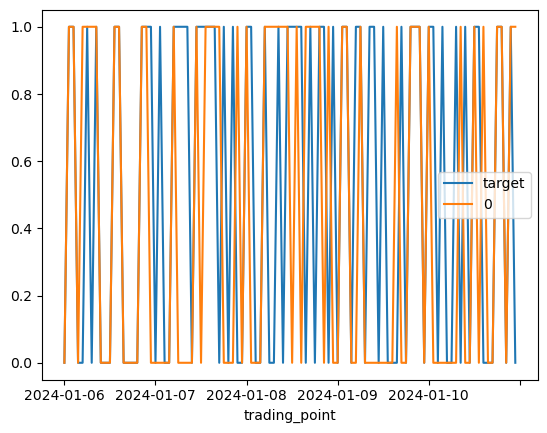

In [13]:
combined.plot();

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

In [15]:
def backtest(data, model, predictors, start=500, step=24):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [16]:
predictions = backtest(eth, rf, predictors)

KeyboardInterrupt: 

In [28]:
predictions['predictions'].value_counts()

0    23165
1    21438
Name: predictions, dtype: int64

In [29]:
precision_score(predictions['target'], predictions['predictions'])
# we were about 54% accurate for 155 days but that good or not?

0.5628789999067078

In [30]:
predictions['target'].value_counts() / predictions.shape[0]
# as a benchmark we can look at a percentage of days where the market actually went up

0    0.504876
1    0.495124
Name: target, dtype: float64

In [31]:
# we are going to predict a variety of rolling averages

In [8]:
horizons = [2,5,60,250,1460] # rolling means - 2 days - 4 years
new_predictors = []

for horizon in horizons:
    rolling_averages = eth.rolling(horizon).mean()
    
    ratio_column = f"close_ratio_{horizon}"
    eth[ratio_column] = eth['close'] / rolling_averages['close']
    
    trend_column = f"trend_{horizon}"
    eth[trend_column] = eth.shift(1).rolling(horizon).sum()['target']
    
    new_predictors += [ratio_column, trend_column]

In [9]:
eth

,open,high,low,close,volume,tomorrow,target,close_ratio_2,trend_2,close_ratio_5,trend_5,close_ratio_60,trend_60,close_ratio_250,trend_250,close_ratio_1460,trend_1460
trading_point,,,,,,,,,,,,,,,,,
2018-05-15,732.10,736.67,730.94,733.00,1.043910e+03,707.38,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-15,700.99,710.15,699.05,707.38,2.558900e+02,700.99,0,0.982213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-15,707.84,711.29,695.74,700.99,1.029830e+03,707.84,1,0.995463,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-15,712.48,714.44,707.39,707.84,1.560700e+02,712.48,1,1.004862,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-15,713.00,714.99,709.41,712.48,4.185700e+02,713.00,1,1.003267,2.0,1.000199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,2376.10,2377.80,2346.40,2348.00,2.997900e+05,2377.80,1,0.996922,0.0,0.989773,2.0,1.010039,32.0,1.024344,120.0,1.073159,715.0
2024-01-10,2399.90,2400.60,2367.10,2377.80,7.287779e+05,2398.10,1,1.006306,1.0,1.002766,2.0,1.022570,32.0,1.037209,120.0,1.086669,716.0
2024-01-10,2346.70,2399.50,2341.60,2398.10,6.251879e+05,2360.60,0,1.004251,2.0,1.010398,2.0,1.030325,33.0,1.045899,120.0,1.095825,717.0


In [10]:
# lots of NaN. When pandas cant find enough days or rows to compute rolling average, it will provide NaN
# trend, we can't include current day. it is looking for 2 days, you'd be including todays target which provides leakage and looks amazing but doesn't work in real world

In [11]:
eth = eth.dropna()

In [12]:
eth

,open,high,low,close,volume,tomorrow,target,close_ratio_2,trend_2,close_ratio_5,trend_5,close_ratio_60,trend_60,close_ratio_250,trend_250,close_ratio_1460,trend_1460
trading_point,,,,,,,,,,,,,,,,,
2018-07-15,451.86,454.94,448.81,449.84,1.073260e+03,450.50,1,0.997760,1.0,1.015573,3.0,1.032790,31.0,0.987183,131.0,0.839266,736.0
2018-07-15,449.84,450.99,447.78,450.50,1.271900e+02,449.54,0,1.000733,1.0,1.009216,4.0,1.033796,31.0,0.988696,131.0,0.840774,737.0
2018-07-15,449.53,449.99,447.41,449.54,6.847000e+01,450.05,1,0.998933,1.0,1.000218,3.0,1.031234,30.0,0.986642,131.0,0.839252,737.0
2018-07-15,449.61,451.00,449.32,450.05,2.306300e+02,453.38,1,1.000567,1.0,0.999316,3.0,1.031974,31.0,0.987843,131.0,0.840481,737.0
2018-07-15,450.05,453.50,449.97,453.38,4.756200e+02,452.41,0,1.003686,2.0,1.006031,3.0,1.039073,31.0,0.995221,131.0,0.846980,737.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,2347.20,2368.40,2345.20,2362.50,1.174468e+05,2348.00,0,0.996163,0.0,0.994352,2.0,1.016862,32.0,1.030751,121.0,1.079875,715.0
2024-01-10,2376.10,2377.80,2346.40,2348.00,2.997900e+05,2377.80,1,0.996922,0.0,0.989773,2.0,1.010039,32.0,1.024344,120.0,1.073159,715.0
2024-01-10,2399.90,2400.60,2367.10,2377.80,7.287779e+05,2398.10,1,1.006306,1.0,1.002766,2.0,1.022570,32.0,1.037209,120.0,1.086669,716.0


In [15]:
def perform_grid_search(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 20, 50, 100],
        'min_samples_leaf': [1, 2, 4, 8],
    }

    gs = GridSearchCV(
        RandomForestClassifier(random_state=2024),
        param_grid=param_grid, cv=5
    )

    gs.fit(X_train, y_train)

    best_params = gs.best_params_

    return best_params

def create_and_fit_best_model(X_train, y_train, best_params):
    best_model = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=2024
    )

    best_model.fit(X_train, y_train)

    return best_model

In [16]:
train = eth.iloc[:-100]
test = eth.iloc[-100:]

X_train = train[new_predictors]
y_train = train['target']

# Perform grid search to find the best hyperparameters
best_params = perform_grid_search(X_train, y_train)

# Create and fit the best model using the obtained best parameters
best_model = create_and_fit_best_model(X_train, y_train, best_params)

KeyboardInterrupt: 

In [38]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict_proba(test[predictors])[:,1] # returns a probability instead of just a 1 or 0
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

In [39]:
def backtest(data, model, predictors, start=1000, step=24):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [40]:
predictions = backtest(eth, best_model, new_predictors) # no longer using ohlcv since they are absolute numbers, not super informative to model. ratios > abs values

KeyboardInterrupt: 

In [ ]:
predictions['predictions'].value_counts()

In [ ]:
# way fewer predictions because we are asking the model to be more confident in its predictions before it predicted the price would go up
# buying in fewer days but hopefully we are more accurate

In [ ]:
precision_score(predictions['target'], predictions['predictions'])